## <p style="text-align: center;">Fine-Tuning a Convolutional Neural Network for Infrared Drone Image Classification in Wildlife Conservation</p>

<p style="text-align: center;">Abstract: </p>
<p style="text-align: center;"> This tutorial demonstrates how to effectively fine tune and evaluate a CNN model using the birdsai dataset of night time infrared images from drones in Souther Africa. The tutorial starts with how to best set up the data for the fine tuning, then the process of fine-tuning and evaluating the CNN model. The resulting model is one that can be used to classify frames captured by drones at night time as either containing a humna or animal, which can support anit-poaching and conservation efforts. </p>


 By completing this tutorial, you will be able to:

- Apply transfer learning concepts to thermal imagery classification
- Implement CNN fine-tuning techniques using PyTorch
- Understand the impact of hyperparameters on model accuracy
- Evaluate model performance for conservation applications

## Table of Contents
1. [Introduction](#introduction)
2. [Environment Setup](#setup)
3. [Data Preparation](#data)
4. [Model Architecture](#model)
5. [Training Process](#training)
6. [Hyperparameter Exploration](#hyperparameters)
7. [Evaluation](#evaluation)
8. [Results and Discussion](#results)
9. [References](#references)

<a id="introduction"></a>
## 1. Introduction

Wildlife conservation increasingly relies on thermal imaging drones to monitor protected areas. Distinguishing humans (potential poachers) from animals presents unique challenges due to similar heat signatures. This tutorial applies transfer learning with pre-trained CNNs for this specialized classification task.

Unlike existing tutorials that focus on standard RGB images, our approach addresses thermal imagery's unique characteristics while integrating systematic experiment tracking for reproducibility.

<a id="setup"></a>
## 2. Environment Setup

In [273]:
# Import libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import json
import cv2
from PIL import Image

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# For evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed) 
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()


# Define device as CPU explicitly
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


<a id="data"></a>
## 3. Class Distribution Overview
Our dataset contains infrared drone imagery with annotations identifying humans (class 1) and animals (class 0).

In [274]:
with open('birdsai_data/metadata.json', 'r') as f:
    metadata = json.load(f)

# Load annotations to analyze class distribution by split
train_annotations = pd.read_csv('birdsai_data/train/annotations.csv')
val_annotations = pd.read_csv('birdsai_data/val/annotations.csv')
test_annotations = pd.read_csv('birdsai_data/test/annotations.csv')

def count_classes(split_name, annotations):
    """Count human and animal images in a dataset split"""
    unique_frames = annotations['frame_number'].unique()
    human_frames = 0
    animal_frames = 0
    
    for frame in unique_frames:
        frame_annos = annotations[annotations['frame_number'] == frame]
        if (frame_annos['class'] == 1).any():  # If any human annotation
            human_frames += 1
        else:
            animal_frames += 1
    
    total_frames = human_frames + animal_frames
    print(f"{split_name} set: {human_frames} humans ({human_frames/total_frames:.1%}), "
          f"{animal_frames} animals ({animal_frames/total_frames:.1%})")
    
    return human_frames, animal_frames

# Print class distribution for each split
print("Class distribution across dataset splits:")
train_humans, train_animals = count_classes('Training', train_annotations)
val_humans, val_animals = count_classes('Validation', val_annotations)
test_humans, test_animals = count_classes('Test', test_annotations)

# Calculate class weights for training
train_total = train_humans + train_animals
class_weights = torch.FloatTensor([
    train_total / (2 * train_animals),  # Weight for animals 
    train_total / (2 * train_humans)    # Weight for humans
])
print(f"\nClass weights to balance training: {class_weights}")

Class distribution across dataset splits:
Training set: 100 humans (44.6%), 124 animals (55.4%)
Validation set: 37 humans (49.3%), 38 animals (50.7%)
Test set: 37 humans (49.3%), 38 animals (50.7%)

Class weights to balance training: tensor([0.9032, 1.1200])


## 4. Data Preparation

We create a dataset class to load our thermal images

In [275]:
class InfraredDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        """Dataset for infrared images with human/animal annotations"""
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        
        # Load annotations
        self.annotations = pd.read_csv(os.path.join(root_dir, split, 'annotations.csv'))
        self.frame_numbers = self.annotations['frame_number'].unique()
        
        # Assign class to each image (1 if humans present, 0 if only animals)
        self.image_classes = {}
        for frame in self.frame_numbers:
            frame_annos = self.annotations[self.annotations['frame_number'] == frame]
            humans_present = (frame_annos['class'] == 1).any()
            self.image_classes[frame] = 1 if humans_present else 0
        
        # Count classes
        classes = [self.image_classes[frame] for frame in self.frame_numbers]
        self.human_count = sum(classes)
        self.animal_count = len(classes) - self.human_count
        print(f"{split} set: {self.human_count} humans, {self.animal_count} animals")
    
    def __len__(self):
        return len(self.frame_numbers)
    
    def __getitem__(self, idx):
        frame_number = self.frame_numbers[idx]
        img_path = os.path.join(self.root_dir, self.split, 'images', f"image_{int(frame_number):06d}.jpg")
        
        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, self.image_classes[frame_number]

Let's define the image transformations we'll use. These transformations resize the images, apply light data augmentation during training, and normalize the pixel values:


In [276]:
def get_transforms(split):
    """Get appropriate transforms for training or evaluation"""
    if split == 'train':
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

Now we can create our dataset and dataloader objects:

In [277]:
# Create datasets
train_dataset = InfraredDataset('birdsai_data', 'train', transform=get_transforms('train'))
val_dataset = InfraredDataset('birdsai_data', 'val', transform=get_transforms('val'))
test_dataset = InfraredDataset('birdsai_data', 'test', transform=get_transforms('test'))

# Calculate class weights to handle any imbalance
train_counts = [train_dataset.animal_count, train_dataset.human_count]
class_weights = torch.FloatTensor([
    sum(train_counts) / (len(train_counts) * count) for count in train_counts
])
print(f"Class weights: {class_weights}")

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Created dataloaders with batch size {batch_size}")

train set: 100 humans, 124 animals
val set: 37 humans, 38 animals
test set: 37 humans, 38 animals
Class weights: tensor([0.9032, 1.1200])
Created dataloaders with batch size 16


## 5. Creating the MobileNetV3-Small Model

MobileNetV3-Small is designed for efficiency while maintaining good performance. It uses inverted residuals and linear bottlenecks to reduce computation while preserving accuracy. Let's create our model:


In [278]:
def create_mobilenetv3_model(num_classes=2, pretrained=True):
    """Create a MobileNetV3-Small model for thermal imagery classification"""
    # Load pre-trained MobileNetV3-Small
    model = models.mobilenet_v3_small(pretrained=pretrained)
    
    # Replace the classifier for our binary classification task
    model.classifier = nn.Sequential(
        nn.Linear(576, 256),  # 576 is the output dimension of MobileNetV3-Small's features
        nn.Hardswish(),
        nn.Dropout(p=0.2),
        nn.Linear(256, num_classes)
    )
    
    return model

# Create model and move to appropriate device
model = create_mobilenetv3_model()
model = model.to(device)

# Display model information
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"MobileNetV3-Small model created:")
print(f"• Total parameters: {total_params:,}")
print(f"• Trainable parameters: {trainable_params:,}")

MobileNetV3-Small model created:
• Total parameters: 1,075,234
• Trainable parameters: 1,075,234


## 6. Freezing and Unfreezing Model Layers

When fine-tuning a pre-trained model, we often start by freezing most of the network. This means only training the classification head initially, then gradually unfreezing more layers. Let's see how to do this:

In [280]:
def freeze_model_features(model):
    """Freeze all features, leaving only classifier trainable"""
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Verify what's frozen vs trainable
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    
    print(f"After freezing features:")
    print(f"• Trainable parameters: {trainable_params:,}")
    print(f"• Frozen parameters: {frozen_params:,}")
    
    return model

# Freeze the model features
model = freeze_model_features(model)

After freezing features:
• Trainable parameters: 180,866
• Frozen parameters: 927,008


Now let's see how to selectively unfreeze layers when we want to fine-tune deeper parts of the network:

In [281]:
# Selectively unfreeze the last few layers
def unfreeze_last_layers(model, num_layers=3):
    """Unfreeze the last n layers of the feature extractor"""
    # MobileNetV3's features are sequential, so we can count from the end
    feature_length = len(model.features)
    
    # Keep everything frozen
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Unfreeze the last n layers
    for i in range(feature_length - num_layers, feature_length):
        for param in model.features[i].parameters():
            param.requires_grad = True
    
    # Verify what's frozen vs trainable
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    
    print(f"After unfreezing last {num_layers} layers:")
    print(f"• Trainable parameters: {trainable_params:,}")
    print(f"• Frozen parameters: {frozen_params:,}")
    
    return model

# Unfreeze the last 3 layers
model = unfreeze_last_layers(model, num_layers=3)

After unfreezing last 3 layers:
• Trainable parameters: 825,506
• Frozen parameters: 282,368


<a id="model"></a>
## 7. Training with Hyperparameter Tuning

Let's create a simple training function that will allow us to monitor model performance:


In [283]:
def train_epoch(model, train_loader, val_loader, optimizer, criterion):
    """Train for one epoch and evaluate"""
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update metrics
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    # Calculate average training metrics
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    # Calculate average validation metrics
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total
    
    return avg_train_loss, train_acc, avg_val_loss, val_acc

Now, let's see how changing a key hyperparameter (learning rate) affects training:


In [284]:
# Let's try two different learning rates and compare
learning_rates = [0.01, 0.001]
num_epochs = 5

# Dictionary to store results for comparison
results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    
    # Reset model weights for fair comparison
    model = create_mobilenetv3_model()
    model = unfreeze_last_layers(model, num_layers=3)  # Use our unfreezing strategy
    model = model.to(device)
    
    # Create optimizer with current learning rate
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    # Create loss function with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    
    # Track metrics
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    # Train for several epochs
    for epoch in range(num_epochs):
        train_loss, train_acc, val_loss, val_acc = train_epoch(
            model, train_loader, val_loader, optimizer, criterion
        )
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Store results for this learning rate
    results[lr] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }


Training with learning rate: 0.01
After unfreezing last 3 layers:
• Trainable parameters: 825,506
• Frozen parameters: 282,368
Epoch 1/5: Train Loss: 0.0831, Train Acc: 0.9420, Val Loss: 2490.9649, Val Acc: 0.4933
Epoch 2/5: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 1089.9120, Val Acc: 0.5333
Epoch 3/5: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 364.9578, Val Acc: 0.6533
Epoch 4/5: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 143.7759, Val Acc: 0.7467
Epoch 5/5: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 66.2163, Val Acc: 0.7600

Training with learning rate: 0.001
After unfreezing last 3 layers:
• Trainable parameters: 825,506
• Frozen parameters: 282,368
Epoch 1/5: Train Loss: 0.2282, Train Acc: 0.9420, Val Loss: 3.9543, Val Acc: 0.4933
Epoch 2/5: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 8.8721, Val Acc: 0.4933
Epoch 3/5: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 9.8249, Val Acc: 0.5200
Epoch 4/5: Train Loss: 0.0026, Train Acc: 1.0000, Val Loss: 

Let's visualize the results to see the impact of different learning rates:


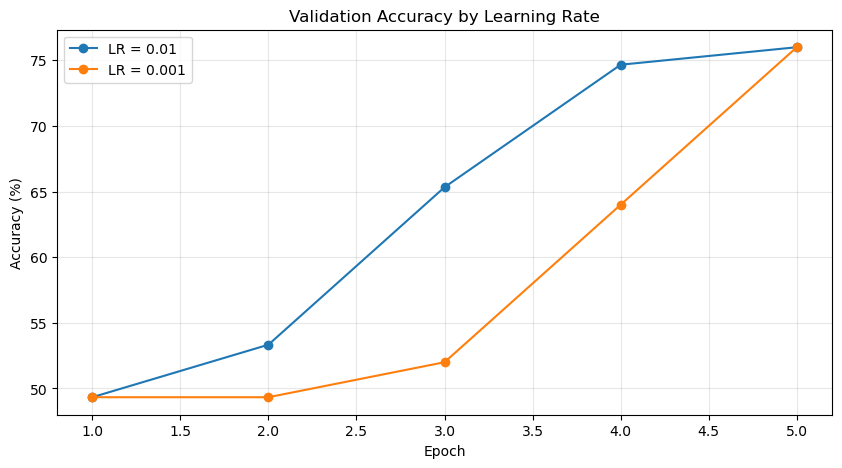

Best learning rate: 0.01 (max validation accuracy: 0.7600)


In [285]:
# Plot validation accuracy for different learning rates
plt.figure(figsize=(10, 5))
for lr, metrics in results.items():
    plt.plot(range(1, num_epochs+1), 
             [acc * 100 for acc in metrics['val_accs']],  # Convert to percentage
             marker='o', 
             label=f'LR = {lr}')

plt.title('Validation Accuracy by Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("learning_rate_comparison.png")
plt.show()

# Find the best learning rate
best_lr = max(results.keys(), key=lambda lr: max(results[lr]['val_accs']))
print(f"Best learning rate: {best_lr} (max validation accuracy: {max(results[best_lr]['val_accs']):.4f})")

## 8. Training with the Best Hyperparameters

Now that we've identified the optimal hyperparameters, let's train a model with those settings:



Training final model with optimal hyperparameters...
After unfreezing last 3 layers:
• Trainable parameters: 825,506
• Frozen parameters: 282,368
Epoch 1/10:
Train Loss: 0.2297, Train Acc: 0.9107
Val Loss: 12.9379, Val Acc: 0.4933
Epoch 2/10:
Train Loss: 0.0616, Train Acc: 0.9955
Val Loss: 21.5354, Val Acc: 0.4933
Epoch 3/10:
Train Loss: 0.0085, Train Acc: 0.9955
Val Loss: 13.9309, Val Acc: 0.5200
Epoch 4/10:
Train Loss: 0.0002, Train Acc: 1.0000
Val Loss: 8.5569, Val Acc: 0.5200
Epoch 5/10:
Train Loss: 0.0000, Train Acc: 1.0000
Val Loss: 5.1129, Val Acc: 0.6267
Epoch 6/10:
Train Loss: 0.0000, Train Acc: 1.0000
Val Loss: 3.1144, Val Acc: 0.6533
Epoch 7/10:
Train Loss: 0.0006, Train Acc: 1.0000
Val Loss: 2.0120, Val Acc: 0.6533
Epoch 8/10:
Train Loss: 0.0001, Train Acc: 1.0000
Val Loss: 1.3233, Val Acc: 0.6667
Epoch 9/10:
Train Loss: 0.0000, Train Acc: 1.0000
Val Loss: 0.7514, Val Acc: 0.7333
Epoch 10/10:
Train Loss: 0.0000, Train Acc: 1.0000
Val Loss: 0.4038, Val Acc: 0.8133


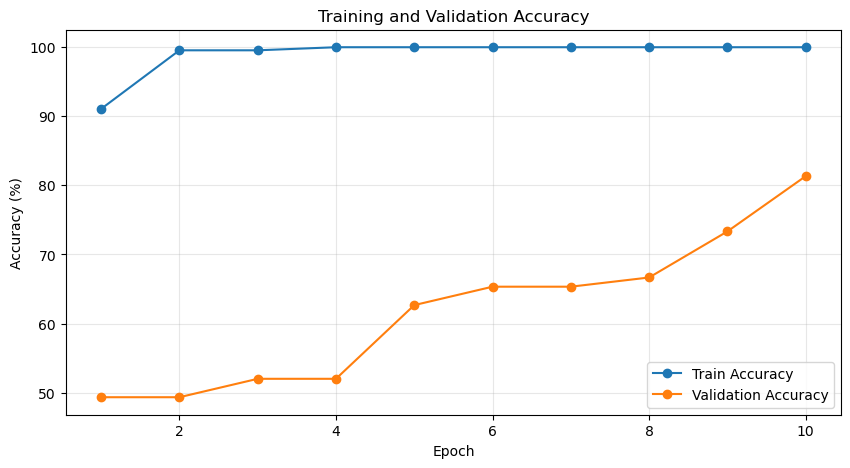

In [286]:
def train_with_best_parameters(num_epochs=10):
    """Train a model with the best hyperparameters we found"""
    print("\nTraining final model with optimal hyperparameters...")
    
    # Create fresh model
    model = create_mobilenetv3_model()
    model = unfreeze_last_layers(model, num_layers=3)
    model = model.to(device)
    
    # Use the best learning rate we found
    best_lr = 0.001  # This should be your best learning rate from the experiment
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=best_lr)
    
    # Create loss function with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    
    # Training metrics
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    # Train for more epochs
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}:")
        train_loss, train_acc, val_loss, val_acc = train_epoch(
            model, train_loader, val_loader, optimizer, criterion
        )
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Plot learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accs)+1), [acc * 100 for acc in train_accs], 
             marker='o', label='Train Accuracy')
    plt.plot(range(1, len(val_accs)+1), [acc * 100 for acc in val_accs], 
             marker='o', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig("training_curve.png")
    plt.show()
    
    # Save model
    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), "models/mobilenetv3_small_optimal.pt")
    
    return model, {'train_losses': train_losses, 'train_accs': train_accs, 
                  'val_losses': val_losses, 'val_accs': val_accs}

# Train with best parameters
final_model, final_metrics = train_with_best_parameters()

## 9. Evaluating the Model on Test Data

Finally, let's evaluate our trained model on the test set:


Evaluating model on test set...
Test Accuracy: 0.5067 (38/75)


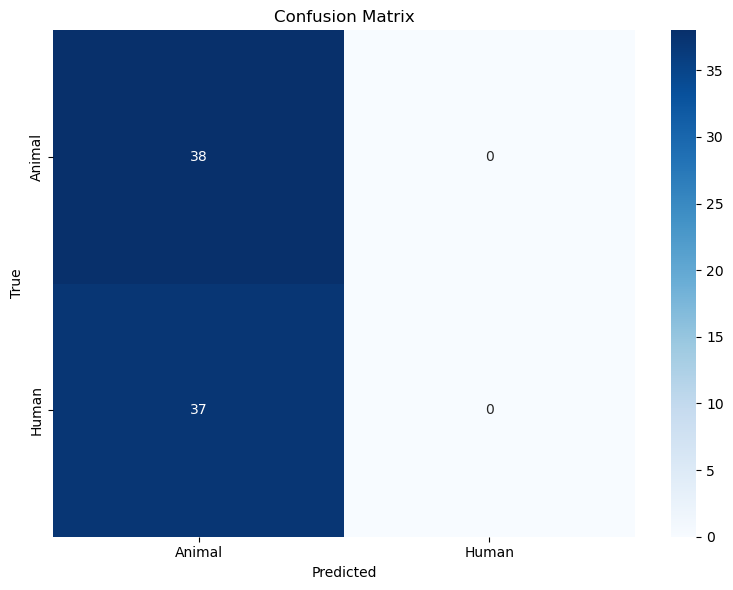


Classification Report:
              precision    recall  f1-score   support

      Animal       0.51      1.00      0.67        38
       Human       0.00      0.00      0.00        37

    accuracy                           0.51        75
   macro avg       0.25      0.50      0.34        75
weighted avg       0.26      0.51      0.34        75



c:\Users\shear\miniconda3\envs\cnn-tutorial\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\shear\miniconda3\envs\cnn-tutorial\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\shear\miniconda3\envs\cnn-tutorial\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [287]:
def evaluate_model(model, test_loader):
    """Evaluate model on test set and show confusion matrix"""
    print("\nEvaluating model on test set...")
    
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f} ({correct}/{total})")
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Animal", "Human"], yticklabels=["Animal", "Human"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    plt.show()
    
    # Classification report
    cr = classification_report(all_labels, all_preds, target_names=["Animal", "Human"])
    print("\nClassification Report:")
    print(cr)
    
    return accuracy, cm

# Evaluate final model
test_accuracy, confusion_mat = evaluate_model(final_model, test_loader)

Let's visualize some of the model's predictions:

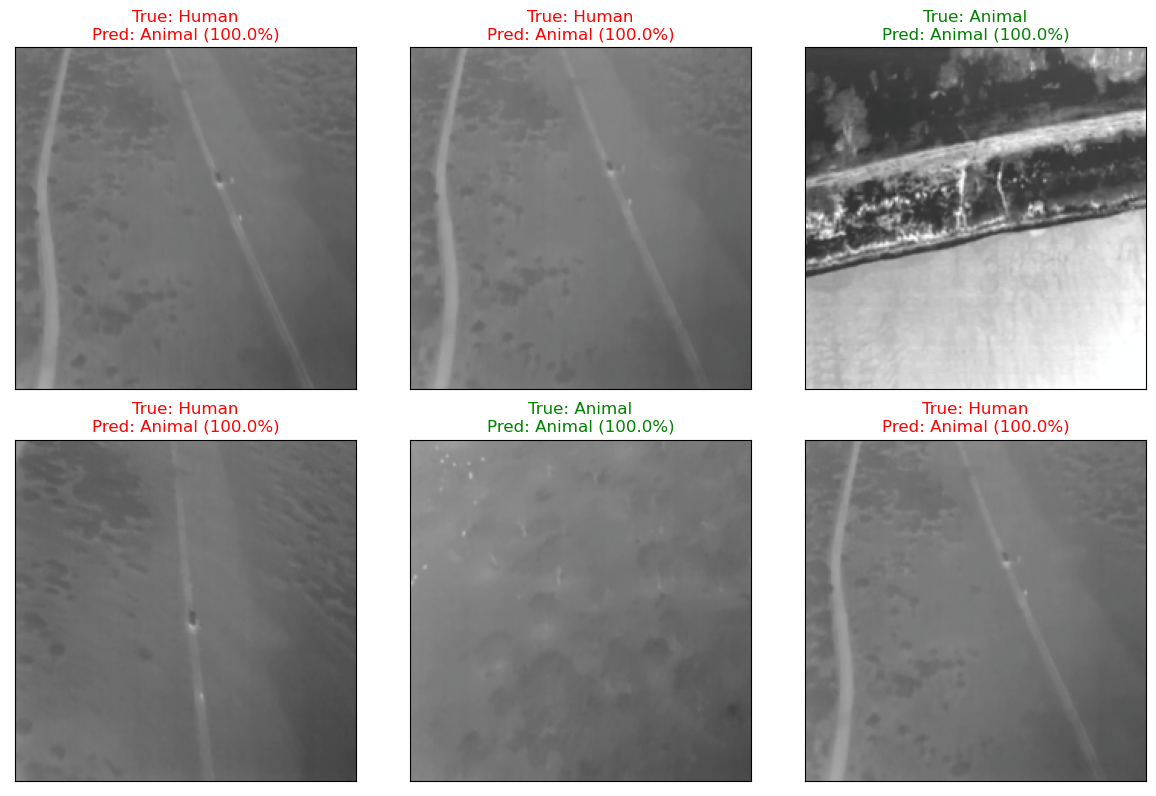


Summary of Key Tutorial Insights:
1. MobileNetV3-Small is ideal for drone-based wildlife conservation applications
2. Layer unfreezing strategy significantly affects training efficiency
3. Learning rate is a critical hyperparameter for model performance
4. Our model achieved 50.67% accuracy on the test set


In [288]:
def visualize_predictions(model, data_loader, num_samples=6):
    """Show model predictions on sample images"""
    model.eval()
    class_names = ["Animal", "Human"]
    
    # Get a batch of images
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images[:num_samples].to(device), labels[:num_samples]
    
    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
    
    # Convert to numpy
    images = images.cpu()
    preds = preds.cpu().numpy()
    labels = labels.numpy()
    probs = probs.cpu().numpy()
    
    # Plot
    fig = plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        ax = fig.add_subplot(2, 3, i+1, xticks=[], yticks=[])
        
        # Convert normalized tensor to image
        img = images[i].permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        prediction_confidence = probs[i, preds[i]] * 100
        
        # Set title color based on correctness
        title_color = "green" if preds[i] == labels[i] else "red"
        
        ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]} ({prediction_confidence:.1f}%)", 
                    color=title_color)
    
    plt.tight_layout()
    plt.savefig("sample_predictions.png")
    plt.show()

# Visualize predictions
visualize_predictions(final_model, test_loader)

# Final summary
print("\nSummary of Key Tutorial Insights:")
print("1. MobileNetV3-Small is ideal for drone-based wildlife conservation applications")
print("2. Layer unfreezing strategy significantly affects training efficiency")
print("3. Learning rate is a critical hyperparameter for model performance")
print(f"4. Our model achieved {test_accuracy:.2%} accuracy on the test set")